### Problem 2
#### Milad Heidari
#### Student Number: 98101469

In [1]:
import torch
import math
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import Lambda
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
from functools import reduce
from operator import add, mul
from torchvision.ops import DropBlock2d
from torchvision import models

In [2]:
# set device to cuda if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# making training and test sets

train_set = datasets.CIFAR10(
    root='data',
    train=True,
    download=False,
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
)

test_set = datasets.CIFAR10(
    root='data',
    train=False,
    download=False,
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
)

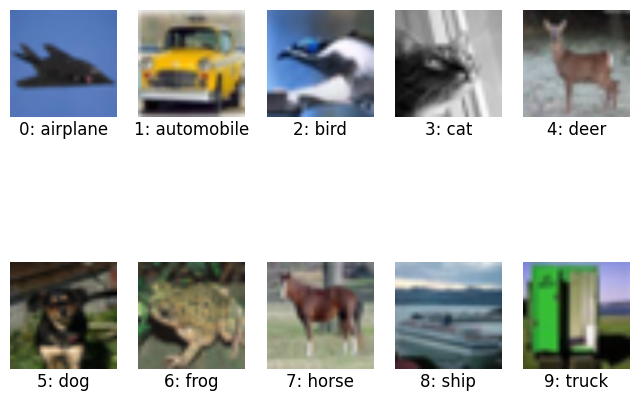

In [4]:
# visualizing random example from each class

label_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
sample_dataloader = DataLoader(train_set, shuffle=True)
data_iterator = iter(sample_dataloader)

fig = plt.figure(figsize=(8, 6))
for i in range(10):
    while True:
        X, y = next(data_iterator)
        if y == i:
            ax = fig.add_subplot(2, 5, i+1)
            ax.set_axis_off()
            img = X.squeeze().permute(1, 2, 0)
            ax.imshow(img.cpu())
            ax.set_title(f'{i}: {label_map[i]}', y=-0.25)
            break

#### A)

In [5]:
# initializing a pretrained model and setting requires_grad to False for convolutional layer
teacher_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for param in teacher_model.parameters():
    param.requires_grad = False

In [6]:
# print structureof the model
teacher_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# change last fully connected layer
in_features = teacher_model.fc.in_features
teacher_model.fc = nn.Linear(in_features, 10)
teacher_model = teacher_model.to(device)

In [8]:
# define which parameters we are going to update during training
params_to_update = [param for param in teacher_model.parameters() if param.requires_grad]
params_to_update

[Parameter containing:
 tensor([[ 0.0125, -0.0140,  0.0189,  ...,  0.0005,  0.0032,  0.0094],
         [-0.0037,  0.0205,  0.0054,  ..., -0.0118,  0.0044, -0.0071],
         [ 0.0065, -0.0027, -0.0148,  ...,  0.0003, -0.0151,  0.0021],
         ...,
         [-0.0009, -0.0189, -0.0168,  ...,  0.0218,  0.0189, -0.0127],
         [ 0.0052,  0.0011,  0.0080,  ...,  0.0072,  0.0204,  0.0130],
         [-0.0109,  0.0012,  0.0189,  ..., -0.0090, -0.0037, -0.0077]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0140,  0.0072,  0.0139, -0.0045, -0.0102,  0.0120,  0.0153, -0.0116,
          0.0127, -0.0061], device='cuda:0', requires_grad=True)]

In [9]:
# setting hyperparameters
learning_rate = 1e-3
batch_size = 30
epochs = 10

In [10]:
# initialize the loss function and choose an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_correct = 0
    for batch_num, (X, y) in enumerate(dataloader):
        # forward prop
        X = X.to(torch.float32).to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        num_correct += (y_pred.argmax(dim=1) == y).sum().item()
        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    accuracy = num_correct / size
    print(f'train_loss: {loss.item()}')
    print(f'Train Accuracy: {np.round(accuracy*100, 2)}%')
    
            
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_correct = 0
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(dataloader):
            X = X.to(torch.float32).to(device)
            y = y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            num_correct += (y_pred.argmax(dim=1) == y).sum().item()
                        
    accuracy = num_correct / size
    print(f'Test Accuracy: {np.round(accuracy*100, 2)}%')

In [12]:
for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, teacher_model, loss_fn, optimizer)
    test_loop(test_dataloader, teacher_model, loss_fn)
    print()

epoch 1 ==================================================
train_loss: 0.3332236409187317
Train Accuracy: 73.64%
Test Accuracy: 78.48%

epoch 2 ==================================================
train_loss: 0.6955637335777283
Train Accuracy: 78.19%
Test Accuracy: 80.19%

epoch 3 ==================================================
train_loss: 0.39762434363365173
Train Accuracy: 78.97%
Test Accuracy: 80.32%

epoch 4 ==================================================
train_loss: 0.7000061273574829
Train Accuracy: 79.56%
Test Accuracy: 81.4%

epoch 5 ==================================================
train_loss: 0.5325541496276855
Train Accuracy: 80.32%
Test Accuracy: 80.26%

epoch 6 ==================================================
train_loss: 0.2772753834724426
Train Accuracy: 80.46%
Test Accuracy: 81.44%

epoch 7 ==================================================
train_loss: 0.9131597280502319
Train Accuracy: 80.98%
Test Accuracy: 82.02%

epoch 8 ========================================

In [12]:
# torch.save(teacher_model, 'P2_teacher.pt')
teacher_model = torch.load('P2_teacher.pt')

#### B)

In [13]:
class StudentTeacherLoss:
    
    def __init__(self, alpha=0.5, tav=0.8, T=1):
        self.alpha = alpha
        self.tav = tav
        self.cross_entropy = nn.CrossEntropyLoss()
        self.T = T
        
    def __call__(self, y_teacher, y_student, y):
        y_teacher = (y_teacher/self.T).softmax(dim=1)
        loss = (1-self.alpha) * self.cross_entropy(y_student, y)
        loss += self.alpha * self.tav**2 * self.cross_entropy(y_student/self.T, y_teacher)
        return loss

In [14]:
# initializing the model
student_model = models.resnet18()
student_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# change last fully connected layer
in_features = student_model.fc.in_features
student_model.fc = nn.Linear(in_features, 10)
student_model = student_model.to(device)

In [16]:
# setting hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 10

In [17]:
# initialize the loss function and choose an optimizer
loss_fn = StudentTeacherLoss(alpha=0.75, tav=0.9, T=5)
optimizer = torch.optim.Adam(student_model.parameters(), lr=learning_rate)
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [18]:
def ts_train_loop(dataloader, teacher_model, student_model, loss_fn, optimizer):
    student_model.train()
    teacher_model.eval()
    size = len(dataloader.dataset)
    num_correct = 0
    for batch_num, (X, y) in enumerate(dataloader):
        # forward prop
        X = X.to(torch.float32).to(device)
        y = y.to(device)
        y_pred_student = student_model(X)
        y_pred_teacher = teacher_model(X)
        loss = loss_fn(y_pred_teacher, y_pred_student, y)
        num_correct += (y_pred_student.argmax(dim=1) == y).sum().item()
        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    accuracy = num_correct / size
    print(f'train_loss: {loss.item()}')
    print(f'Train Accuracy: {np.round(accuracy*100, 2)}%')
    
            
def ts_test_loop(dataloader, student_model, loss_fn):
    student_model.eval()
    size = len(dataloader.dataset)
    num_correct = 0
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(dataloader):
            X = X.to(torch.float32).to(device)
            y = y.to(device)
            y_pred = student_model(X)
            num_correct += (y_pred.argmax(dim=1) == y).sum().item()
                        
    accuracy = num_correct / size
    print(f'Test Accuracy: {np.round(accuracy*100, 2)}%')

In [19]:
for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    ts_train_loop(train_dataloader, teacher_model, student_model, loss_fn, optimizer)
    ts_test_loop(test_dataloader, student_model, loss_fn)
    print()

epoch 1 ==================================================
train_loss: 1.8345624208450317
Train Accuracy: 50.65%
Test Accuracy: 61.7%

epoch 2 ==================================================
train_loss: 1.5277583599090576
Train Accuracy: 72.18%
Test Accuracy: 75.07%

epoch 3 ==================================================
train_loss: 1.3717710971832275
Train Accuracy: 80.11%
Test Accuracy: 75.15%

epoch 4 ==================================================
train_loss: 1.3366854190826416
Train Accuracy: 84.45%
Test Accuracy: 80.18%

epoch 5 ==================================================
train_loss: 1.3055391311645508
Train Accuracy: 88.1%
Test Accuracy: 80.96%

epoch 6 ==================================================
train_loss: 1.3393059968948364
Train Accuracy: 91.28%
Test Accuracy: 81.57%

epoch 7 ==================================================
train_loss: 1.2665224075317383
Train Accuracy: 94.11%
Test Accuracy: 84.9%

epoch 8 ===========================================

In [7]:
# torch.save(teacher_model, 'P2_student.pt')
teacher_model = torch.load('P2_teacher.pt')

#### C)

In [12]:
# initializing the model
model = models.resnet18()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# change last fully connected layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 10)
model = model.to(device)

In [14]:
# setting hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [15]:
# initialize the loss function and choose an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [16]:
for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    print()

epoch 1 ==================================================
train_loss: 1.1666295528411865
Train Accuracy: 49.73%
Test Accuracy: 56.53%

epoch 2 ==================================================
train_loss: 0.8050110340118408
Train Accuracy: 69.55%
Test Accuracy: 68.76%

epoch 3 ==================================================
train_loss: 0.4102746248245239
Train Accuracy: 77.8%
Test Accuracy: 72.58%

epoch 4 ==================================================
train_loss: 0.8496277928352356
Train Accuracy: 82.36%
Test Accuracy: 78.32%

epoch 5 ==================================================
train_loss: 0.08225209265947342
Train Accuracy: 85.91%
Test Accuracy: 80.92%



In [17]:
# torch.save(model, 'resnet18_from_scratch.pt')
model = torch.load('resnet18_from_scratch.pt')

We see that when training the model from scratch, it underfits, since it's not complex enough to learn the patterns in data. On the other hand, using a teacher model to teach the student network, it performs much better because it learns the complex patterns extracted by teacher model too.

#### D)

In [12]:
# initializing the model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# change last fully connected layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 10)
model = model.to(device)

In [14]:
# setting hyperparameters
learning_rate = 1e-3
batch_size = 16
epochs = 5

In [15]:
# initialize the loss function and choose an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [16]:
for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    print()

epoch 1 ==================================================
train_loss: 1.2796692848205566
Train Accuracy: 54.42%
Test Accuracy: 69.26%

epoch 2 ==================================================
train_loss: 0.854816734790802
Train Accuracy: 73.14%
Test Accuracy: 77.24%

epoch 3 ==================================================
train_loss: 0.42237645387649536
Train Accuracy: 79.8%
Test Accuracy: 77.7%

epoch 4 ==================================================
train_loss: 0.26209312677383423
Train Accuracy: 83.67%
Test Accuracy: 81.05%

epoch 5 ==================================================
train_loss: 0.6559271216392517
Train Accuracy: 86.62%
Test Accuracy: 84.3%



It takes much longer time to fine tune the model than freezing the CNN layers and just learning the last MLP network. Also, the result is almost the same. The reason is the `ImageNet` dataset is much larger than the `CIFAR-10` and the features extracted on `ImageNet` is likely to work well on `CIFAR-10` and we only need to train the last MLP layer to predict the probability of the classes.